In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from new_function import *
from new_code import *

In [2]:
import numpy as np

def init_x_func(n=6, d=10, seed=42):
    np.random.seed(seed)
    return 0.01 * np.random.normal(size=(n, d))

def stable_log_exp(x):
    """Stable computation of log(1 + exp(x)) to avoid overflow."""
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

def loss(x, y, h, rho=0.001):
    n, L, d = h.shape
    x = x.reshape(-1)
    
    # 计算 h_dot_x
    h_dot_x = np.einsum('ijk,k->ij', h, x)  # (n, L)
    
    # 计算 stable_log_exp
    term1 = np.sum(stable_log_exp(-y * h_dot_x)) / L  # 标量
    
    # 计算正则化项
    term2 = np.sum(rho * x**2 / (1 + x**2))  # 标量
    
    return term1 + term2

def grad(x, y, h, rho=0.001):
    n, L, d = h.shape
    
    # 计算 h_dot_x
    h_dot_x = np.einsum('ijk,ik->ij', h, x)  # (n, L)
    
    # 计算 exp_val 并处理溢出
    exp_val = np.exp(y * h_dot_x)
    np.clip(exp_val, None, 1e300, out=exp_val)  # 防止数值溢出
    
    # 计算 g1
    g1 = -np.einsum('ijk,ij->ik', h, y / (1 + exp_val)) / L  # (n, d)
    
    # 计算 g2
    g2 = 2 * x / (1 + x ** 2) ** 2  # (n, d)
    
    # 返回最终的梯度
    return (g1 + g2 * rho).reshape(n, d)

def grad_f_bar_x(x, y, h, rho=0.001):
    # 调用 grad 函数计算梯度
    output = grad(x, y, h, rho)
    # 计算所有节点梯度的平均值
    return np.mean(output, axis=0)

def compute_accuracy(x, X_test, y_test):
    # 计算均值 w
    w = np.mean(x, axis=0)

    # 计算 z = np.dot(X_test, w) 的向量化版本
    z = np.dot(X_test, w)

    # 计算概率
    prob = 1 / (1 + np.exp(-z))

    # 计算预测结果
    y_out = np.where(prob >= 0.5, 1, -1)

    # 计算正确和错误的预测次数
    right = np.sum(y_out == y_test)
    false = y_out.size - right

    # 计算准确率
    accuracy = right / (right + false)
    return accuracy

In [3]:
#计算kappa
def compute_kappa_row(A):
    pi=get_left_perron(A)
    return np.max(pi)/np.min(pi)

def compute_kappa_col(B):
    pi=get_right_perron(B)
    return np.max(pi)/np.min(pi)

#计算第二大特征值的模长
def compute_2st_eig_value(A):
    return abs(np.linalg.eigvals(A)[1])

#计算beta
import numpy as np
import networkx as nx
from mpmath import mp

def compute_beta_row(A, precision=64):
    mp.dps = precision  # 设置计算精度
    n = A.shape[0]
    pi = get_left_perron(A)
    one = np.ones(n)
    if not nx.is_strongly_connected(nx.DiGraph(A)):
        print("不是强联通")
    matrix = A - np.outer(one, pi)
    diag1 = np.diag(np.sqrt(pi))
    diag1_inverse = np.diag(1 / np.sqrt(pi))
    result = np.linalg.norm(diag1 @ matrix @ diag1_inverse, 2)
    return min(result, 1)  # 裁剪结果不超过1

def compute_beta_col(B, precision=64):
    mp.dps = precision  # 设置计算精度
    n = B.shape[0]
    pi = get_right_perron(B)
    one = np.ones(n)
    if not nx.is_strongly_connected(nx.DiGraph(B)):
        print("不是强联通")
    matrix = B - np.outer(pi, one)
    diag1 = np.diag(np.sqrt(pi))
    diag1_inverse = np.diag(1 / np.sqrt(pi))
    result = np.linalg.norm(diag1_inverse @ matrix @ diag1, 2)
    return min(result, 1)  # 裁剪结果不超过1


def compute_S_A_row(A):
    kappa=compute_kappa_row(A)
    beta=compute_beta_row(A)
    n=A.shape[0]
    output=2*np.sqrt(n)*(1+np.log(kappa))/(1-beta)
    return output

def compute_S_B_col(B):
    kappa=compute_kappa_col(B)
    beta=compute_beta_col(B)
    n=B.shape[0]
    output=2*np.sqrt(n)*(1+np.log(kappa))/(1-beta)
    return output
#展式
def show_row(A):
    print("A的第二大特征值:",compute_2st_eig_value(A))
    print("A的beta:",compute_beta_row(A))
    print("A的spectral gap:",1-compute_beta_row(A))
    print("A的kappa:",compute_kappa_row(A))
    print("S_A是:",compute_S_A_row(A),"\n")

def show_col(B):
    print("B的第二大特征值:",compute_2st_eig_value(B))
    print("B的beta",compute_beta_col(B))
    print("B的spectral gap:",1-compute_beta_col(B))
    print("B的kappa:",compute_kappa_col(B))
    print("S_B是:",compute_S_B_col(B),"\n")

def compute_coefficient(A,B):
    pi_l=get_left_perron(A)
    pi_r=get_right_perron(B)
    n=A.shape[0]
    return n*np.dot(pi_l,pi_r)

In [4]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
def load_data():
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')
    X = X / 255.0  # 归一化
    y = y.astype(int)  # 确保标签是整数

    # 选择数字3和8
    mask = (y == 3) | (y == 8)
    X_filtered = X[mask]
    y_filtered = y[mask]

    # 将标签转换为二分类，3为1，8为-1
    y_filtered = np.where(y_filtered == 3, 1, -1)

    return X_filtered, y_filtered

def split_data(X, y, test_ratio=0.2, seed=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=seed)
    return X_train, X_test, y_train, y_test

def distribute_data(X, y, n_nodes):
    """ 均分 """
    n_samples_per_node = len(X) // n_nodes
    nodes_data = []
    for i in range(n_nodes):
        start = i * n_samples_per_node
        if i == n_nodes - 1:  # 最后一个节点取所有剩余数据
            end = len(X)
        else:
            end = start + n_samples_per_node
        nodes_data.append((X[start:end], y[start:end]))
    return nodes_data

In [6]:
def load_data_1():
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')
    X = X / 255.0  # Normalize
    y = y.astype(int)  # Ensure labels are integers

    # Classify odd and even numbers
    # Even numbers will be labeled as -1, odd numbers as 1
    y_binary = np.where(y % 2 == 0, -1, 1)

    return X, y_binary

def split_data(X, y, test_ratio=0.2, seed=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=seed)
    return X_train, X_test, y_train, y_test

def distribute_data(X, y, n_nodes):
    """均分"""
    n_samples_per_node = len(X) // n_nodes
    end = n_samples_per_node * n_nodes
    X = X[:end]
    y = y[:end]
    
    nodes_data = []
    for i in range(n_nodes):
        start = i * n_samples_per_node
        end = start + n_samples_per_node
        nodes_data.append((X[start:end], y[start:end]))
    
    return nodes_data

实验1

In [7]:
n=10
d=5
L=200

I=np.eye(n)
B=generate_column_stochastic_matrix(n=n,seed_location=33,seed_num=449,seed_value=2292)
A=column_to_row_stochastic(B,seed=91)
#A=0.999*I+0.001*A
show_row(A)
show_col(B)

print(compute_coefficient(A,B))

A的第二大特征值: 0.6111734749124906
A的beta: 0.7483122437548774
A的spectral gap: 0.25168775624512263
A的kappa: 42.77387384457195
S_A是: 119.50969316695038 

B的第二大特征值: 0.501471460571966
B的beta 0.9437168442650957
B的spectral gap: 0.05628315573490428
B的kappa: 37.48199836798477
S_B是: 519.5846408771254 

0.9413505423356544


In [8]:
init_x=init_x_func(n=n,d=d,seed=42)

h,y,x_opt,x_star=init_data(n=n,d=d,L=L,seed=4989,sigma_h=30)

In [9]:
max_it, history_gradient_two_norm, cs_error, loss_history, x=push_pull_no_accuracy(A=A, B=B, init_x=init_x, h_data=h, y_data=y, grad_func=grad, loss_func=loss, grad_f_bar_func=grad_f_bar_x, d=d, L=L, rho=1, lr=5e-4,sigma_n=1e-5, max_it=21000, mg=1, decay=1)

output01_pp = pd.DataFrame({
        "Iteration": range(1 + max_it),
        "Gradient_two_norm": history_gradient_two_norm,
        "Consensus_error": cs_error,
        "Loss": loss_history,
        #"Accuracy":accuracy,
    })

output01_pp

,Iteration,Gradient_two_norm,Consensus_error,Loss
0,0,4.626706e-02,3.926919e-02,6.928416
1,1,4.749700e-02,2.179082e-02,6.927944
2,2,4.603239e-02,8.384725e-03,6.927590
3,3,4.518608e-02,4.214107e-03,6.927316
4,4,4.524032e-02,2.695434e-03,6.927337
...,...,...,...,...
20996,20996,2.054844e-07,6.905684e-08,6.917045
20997,20997,2.095155e-07,7.040442e-08,6.917045
20998,20998,2.127664e-07,7.272301e-08,6.917045
20999,20999,2.160336e-07,6.030702e-08,6.917045


In [10]:
max_it, history_gradient_two_norm, cs_error, loss_history, x=push_diging_no_accuracy(C=B, init_x=init_x, h_data=h, y_data=y, grad_func=grad, loss_func=loss, grad_f_bar_func=grad_f_bar_x, d=d, L=L, rho=1, lr=5e-4,sigma_n=1e-5, max_it=21000, mg=1, decay=1)

output01_pd = pd.DataFrame({
        "Iteration": range(1 + max_it),
        "Gradient_two_norm": history_gradient_two_norm,
        "Consensus_error": cs_error,
        "Loss": loss_history,
        #"Accuracy":accuracy,
    })

output01_pd

,Iteration,Gradient_two_norm,Consensus_error,Loss
0,0,4.626706e-02,3.926919e-02,6.928416
1,1,4.659669e-02,2.041479e-02,6.927915
2,2,4.543579e-02,1.228997e-02,6.927478
3,3,4.552757e-02,8.444499e-03,6.927377
4,4,4.613508e-02,5.056824e-03,6.927494
...,...,...,...,...
20996,20996,1.355605e-07,4.400558e-08,6.917045
20997,20997,1.404248e-07,5.245449e-08,6.917045
20998,20998,1.339409e-07,4.270175e-08,6.917045
20999,20999,1.431222e-07,3.508601e-08,6.917045


In [11]:
max_it, history_gradient_two_norm, cs_error, loss_history, x=push_pull_change_no_accuracy(A=A, B=B, init_x=init_x, h_data=h, y_data=y, grad_func=grad, loss_func=loss, grad_f_bar_func=grad_f_bar_x, d=d, L=L, rho=1, lr=5e-4,sigma_n=1e-5, max_it=21000, mg=1, decay=1)

output01_pp_222 = pd.DataFrame({
        "Iteration": range(1 + max_it),
        "Gradient_two_norm": history_gradient_two_norm,
        "Consensus_error": cs_error,
        "Loss": loss_history,
        #"Accuracy":accuracy,
    })

output01_pp_222

,Iteration,Gradient_two_norm,Consensus_error,Loss
0,0,4.626706e-02,3.926919e-02,6.928416
1,1,4.737082e-02,2.153413e-02,6.927904
2,2,4.581373e-02,7.893257e-03,6.927532
3,3,4.492060e-02,3.872981e-03,6.927250
4,4,4.498829e-02,2.509235e-03,6.927276
...,...,...,...,...
20996,20996,5.519118e-08,1.635342e-07,6.917045
20997,20997,6.498947e-08,1.384956e-07,6.917045
20998,20998,9.231937e-08,1.861477e-07,6.917045
20999,20999,9.316864e-08,1.357378e-07,6.917045


In [12]:
max_it, history_gradient_two_norm, cs_error, loss_history, x,_=new_pull_sum(A=A, init_x=init_x, h_data=h, y_data=y, grad_func=grad, loss_func=loss, grad_f_bar_func=grad_f_bar_x, d=d, L=L, rho=1, lr=5e-4,sigma_n=1e-5, max_it=21000, mg=1, decay=1)

output01_np = pd.DataFrame({
        "Iteration": range(1 + max_it),
        "Gradient_two_norm": history_gradient_two_norm,
        "Consensus_error": cs_error,
        "Loss": loss_history,
        #"Accuracy":accuracy,
    })

output01_np

,Iteration,Gradient_two_norm,Consensus_error,Loss
0,0,4.626706e-02,3.926919e-02,6.928416
1,1,4.741879e-02,2.161007e-02,6.927926
2,2,4.593308e-02,8.105133e-03,6.927560
3,3,4.519904e-02,4.171720e-03,6.927309
4,4,4.527027e-02,2.613320e-03,6.927338
...,...,...,...,...
20996,20996,2.055295e-07,1.416559e-07,6.917045
20997,20997,1.729620e-07,3.133008e-07,6.917045
20998,20998,1.768149e-07,1.699029e-07,6.917045
20999,20999,1.848255e-07,1.502616e-07,6.917045


In [ ]:
max_it, history_gradient_two_norm, cs_error, loss_history, x=pull_sum(A=A, init_x=init_x, h_data=h, y_data=y, grad_func=grad, loss_func=loss, grad_f_bar_func=grad_f_bar_x, d=d, L=L, rho=1, lr=5e-4,sigma_n=1e-5, max_it=21000, mg=1, decay=1)

output01_ps = pd.DataFrame({
        "Iteration": range(1 + max_it),
        "Gradient_two_norm": history_gradient_two_norm,
        "Consensus_error": cs_error,
        "Loss": loss_history,
        #"Accuracy":accuracy,
    })

output01_ps

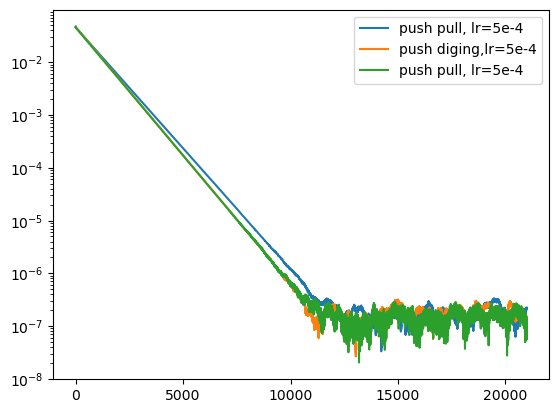

In [14]:
plt.semilogy(output01_pp["Gradient_two_norm"],label='push pull, lr=5e-4')
plt.semilogy(output01_pd["Gradient_two_norm"],label='push diging,lr=5e-4')
plt.semilogy(output01_pp_222["Gradient_two_norm"],label='push pull, lr=5e-4')
plt.legend()
plt.show()

In [15]:
output01_pp.to_csv("pd_better_pp.csv")
output01_pd.to_csv("pd_better_pd.csv")

实验二

In [16]:
n=6
d=5
L=200

I=np.eye(n)
A=generate_row_stochastic_matrix(n=n,seed_location=37,seed_num=33,seed_value=94)
#B=row_to_column_stochastic(A,seed=850)
#B=0.95*I+0.05*B
B=get_B(A,9,n)
show_row(A)
show_col(B)

print(compute_coefficient(A,B))

A的第二大特征值: 0.3943701963677673
A的beta: 0.8573510236085763
A的spectral gap: 0.1426489763914237
A的kappa: 15.986429058268227
S_A是: 129.532494565606 

B的第二大特征值: 0.5048167052111483
B的beta 0.8570869865433615
B的spectral gap: 0.14291301345663854
B的kappa: 16.12273764671767
S_B是: 129.58422383201798 

1.381356915235224


In [10]:
init_x = init_x_func(n=n, d=d, seed=465)
h,y,x_opt,x_star=init_data(n=n,d=d,L=L,seed=4989,sigma_h=30)

In [11]:
max_it, history_gradient_two_norm, cs_error, loss_history, x=push_pull_no_accuracy(A=A, B=B, init_x=init_x, h_data=h, y_data=y, grad_func=grad, loss_func=loss, grad_f_bar_func=grad_f_bar_x, d=d, L=L, rho=10, lr=1e-4,sigma_n=1e-7, max_it=30000, mg=1, decay=1)

output02_pp = pd.DataFrame({
        "Iteration": range(1 + max_it),
        "Gradient_two_norm": history_gradient_two_norm,
        "Consensus_error": cs_error,
        "Loss": loss_history,
        #"Accuracy":accuracy,
    })

output02_pp

,Iteration,Gradient_two_norm,Consensus_error,Loss
0,0,2.859214e-01,4.080200e-02,4.164711
1,1,2.275183e-01,2.041914e-02,4.160955
2,2,2.357048e-01,1.077668e-02,4.159767
3,3,2.520774e-01,4.600697e-03,4.160416
4,4,2.460465e-01,1.893308e-03,4.159984
...,...,...,...,...
29996,29996,4.208435e-09,1.136100e-10,4.154215
29997,29997,4.268359e-09,1.184629e-10,4.154215
29998,29998,4.192343e-09,1.238058e-10,4.154215
29999,29999,4.159369e-09,1.397361e-10,4.154215


In [12]:
max_it, history_gradient_two_norm, cs_error, loss_history, x=push_pull_change_no_accuracy(A=A, B=B, init_x=init_x, h_data=h, y_data=y, grad_func=grad, loss_func=loss, grad_f_bar_func=grad_f_bar_x, d=d, L=L, rho=10, lr=1e-4,sigma_n=1e-7, max_it=30000, mg=1, decay=1)

output02_pp_222 = pd.DataFrame({
        "Iteration": range(1 + max_it),
        "Gradient_two_norm": history_gradient_two_norm,
        "Consensus_error": cs_error,
        "Loss": loss_history,
        #"Accuracy":accuracy,
    })

output02_pp_222

,Iteration,Gradient_two_norm,Consensus_error,Loss
0,0,2.859214e-01,4.080200e-02,4.164711
1,1,2.274015e-01,2.034520e-02,4.160949
2,2,2.356879e-01,1.084563e-02,4.159766
3,3,2.523005e-01,4.813750e-03,4.160447
4,4,2.460952e-01,1.989644e-03,4.159988
...,...,...,...,...
29996,29996,4.366089e-09,1.828924e-10,4.154215
29997,29997,4.730787e-09,1.529551e-10,4.154215
29998,29998,5.122236e-09,1.755015e-10,4.154215
29999,29999,4.923169e-09,2.350627e-10,4.154215


In [13]:
max_it, history_gradient_two_norm, cs_error, loss_history, x=push_diging_no_accuracy(C=B, init_x=init_x, h_data=h, y_data=y, grad_func=grad, loss_func=loss, grad_f_bar_func=grad_f_bar_x, d=d, L=L, rho=10, lr=1e-4,sigma_n=1e-7, max_it=30000, mg=1, decay=1)

output02_pd = pd.DataFrame({
        "Iteration": range(1 + max_it),
        "Gradient_two_norm": history_gradient_two_norm,
        "Consensus_error": cs_error,
        "Loss": loss_history,
        #"Accuracy":accuracy,
    })

output02_pd

,Iteration,Gradient_two_norm,Consensus_error,Loss
0,0,2.859214e-01,4.080200e-02,4.164711
1,1,2.933989e-01,2.558713e-02,4.162583
2,2,2.742453e-01,1.629130e-02,4.160841
3,3,2.828045e-01,8.620171e-03,4.161018
4,4,2.754246e-01,5.793244e-03,4.160494
...,...,...,...,...
29996,29996,2.342452e-09,8.333570e-11,4.154215
29997,29997,2.146484e-09,8.978141e-11,4.154215
29998,29998,2.419411e-09,1.013340e-10,4.154215
29999,29999,1.827548e-09,9.725552e-11,4.154215


In [15]:
max_it, history_gradient_two_norm, cs_error, loss_history, x,B1=new_pull_sum(A=A,  init_x=init_x, h_data=h, y_data=y, grad_func=grad, loss_func=loss, grad_f_bar_func=grad_f_bar_x, d=d, L=L, rho=10, lr=1e-4,sigma_n=1e-7, max_it=30000, mg=1, decay=1)

output02_np = pd.DataFrame({
        "Iteration": range(1 + max_it),
        "Gradient_two_norm": history_gradient_two_norm,
        "Consensus_error": cs_error,
        "Loss": loss_history,
        #"Accuracy":accuracy,
    })

output02_np



,Iteration,Gradient_two_norm,Consensus_error,Loss
0,0,2.859214e-01,4.080200e-02,4.164711
1,1,2.272936e-01,2.031672e-02,4.160947
2,2,2.357025e-01,1.079866e-02,4.159763
3,3,2.522676e-01,4.762564e-03,4.160441
4,4,2.460193e-01,1.942353e-03,4.159985
...,...,...,...,...
29996,29996,2.638629e-09,2.252739e-10,4.154215
29997,29997,2.818865e-09,2.694995e-10,4.154215
29998,29998,3.050700e-09,1.915768e-10,4.154215
29999,29999,2.557377e-09,1.612879e-10,4.154215


In [14]:
max_it, history_gradient_two_norm, cs_error, loss_history, x=pull_sum(A=A, init_x=init_x, h_data=h, y_data=y, grad_func=grad, loss_func=loss, grad_f_bar_func=grad_f_bar_x, d=d, L=L, rho=10, lr=1e-4,sigma_n=1e-7, max_it=30000, mg=1, decay=1)

output02_ps = pd.DataFrame({
        "Iteration": range(1 + max_it),
        "Gradient_two_norm": history_gradient_two_norm,
        "Consensus_error": cs_error,
        "Loss": loss_history,
        #"Accuracy":accuracy,
    })

output02_ps

,Iteration,Gradient_two_norm,Consensus_error,Loss
0,0,2.859214e-01,4.080200e-02,4.164711
1,1,2.275183e-01,2.041914e-02,4.160955
2,2,2.357603e-01,1.079413e-02,4.159768
3,3,2.511734e-01,4.698060e-03,4.160391
4,4,2.406060e-01,2.319445e-03,4.159825
...,...,...,...,...
29996,29996,8.097295e-09,7.241792e-10,4.154215
29997,29997,8.286030e-09,9.795621e-10,4.154215
29998,29998,1.048987e-08,1.193848e-09,4.154215
29999,29999,1.065328e-08,7.897787e-10,4.154215


In [23]:
I=np.eye(n)
A=generate_row_stochastic_matrix(n=n,seed_location=37,seed_num=33,seed_value=94)
B=row_to_column_stochastic(A,seed=850)
B=0.95*I+0.05*B


A=0.9999*I+0.0001*A


show_row(A)
show_col(B)

print(compute_coefficient(A,B))

A的第二大特征值: 0.9998904071280836
A的beta: 0.9999573681230409
A的spectral gap: 4.263187695907611e-05
A的kappa: 15.986429058058038
S_A是: 433423.97935902124 

B的第二大特征值: 0.9499640553720075
B的beta 0.9947715318952348
B的spectral gap: 0.005228468104765183
B的kappa: 1326.1720621358838
S_B是: 7673.92963878418 

1.9245753546174464


In [24]:
max_it, history_gradient_two_norm, cs_error, loss_history, x=push_pull_no_accuracy(A=A, B=B, init_x=init_x, h_data=h, y_data=y, grad_func=grad, loss_func=loss, grad_f_bar_func=grad_f_bar_x, d=d, L=L, rho=10, lr=1e-4,sigma_n=1e-7, max_it=100000, mg=1, decay=1)

output02_pp2 = pd.DataFrame({
        "Iteration": range(1 + max_it),
        "Gradient_two_norm": history_gradient_two_norm,
        "Consensus_error": cs_error,
        "Loss": loss_history,
        #"Accuracy":accuracy,
    })

output02_pp2

,Iteration,Gradient_two_norm,Consensus_error,Loss
0,0,0.285921,0.040802,4.164711
1,1,0.285335,0.040708,4.164675
2,2,0.284750,0.040616,4.164639
3,3,0.284166,0.040527,4.164604
4,4,0.283584,0.040439,4.164570
...,...,...,...,...
99996,99996,0.000009,0.000259,4.154215
99997,99997,0.000009,0.000259,4.154215
99998,99998,0.000009,0.000259,4.154215
99999,99999,0.000009,0.000259,4.154215


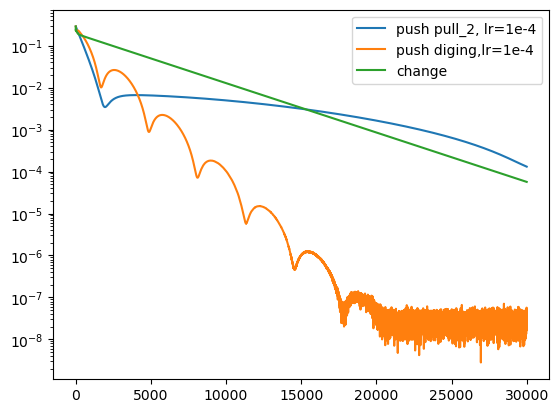

In [25]:
plt.semilogy(output02_pp2["Gradient_two_norm"][:30000],label='push pull_2, lr=1e-4')
plt.semilogy(output02_pd["Gradient_two_norm"][:],label='push diging,lr=1e-4')
plt.semilogy(output02_pp_222["Gradient_two_norm"][:],label='change')
plt.legend()
plt.show()

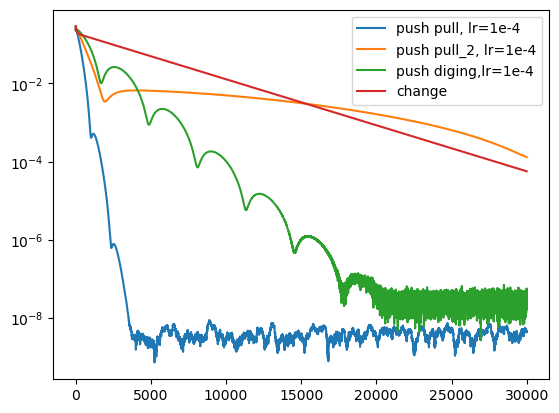

In [26]:
plt.semilogy(output02_pp["Gradient_two_norm"][:],label='push pull, lr=1e-4')
plt.semilogy(output02_pp2["Gradient_two_norm"][:30000],label='push pull_2, lr=1e-4')
plt.semilogy(output02_pd["Gradient_two_norm"][:],label='push diging,lr=1e-4')
plt.semilogy(output02_pp_222["Gradient_two_norm"][:],label='change')
plt.legend()
plt.show()

In [27]:
output02_pp.to_csv("pp_better_pp.csv")
output02_pd.to_csv("pp_better_pd.csv")

实验3

In [28]:
n=7
d=5
L=200

I=np.eye(n)
one=np.ones(n)

array1=np.array([1]+6*[1e-3])
array1=array1/array1.sum()
array2=np.array([1e-3]+[1]+5*[1e-3])
array2=array2/array2.sum()

B=np.outer(array1,one)
show_col(B)
A1=B.T
print("c1=",compute_coefficient(A1,B),' \n ')

A2=np.outer(one,array2)
show_row(A2)
print('c2=', compute_coefficient(A2,B))

B的第二大特征值: 2.1371654926758116e-19
B的beta 1.1325027323603497e-16
B的spectral gap: 0.9999999999999999
B的kappa: 1000.0000000000002
S_B是: 41.84390779388986 

c1= 6.9167914975356695  
 
A的第二大特征值: 9.932868448816188e-21
A的beta: 1.7441883058865392e-16
A的spectral gap: 0.9999999999999998
A的kappa: 999.9999999999994
S_A是: 41.84390779388986 

c2= 0.013868083744056578


In [29]:
init_x = init_x_func(n=n, d=d, seed=465)
h,y,x_opt,x_star=init_data(n=n,d=d,L=L,seed=4989,sigma_h=30)

In [30]:
max_it, history_gradient_two_norm, cs_error, loss_history, x=push_pull_change_no_accuracy(A=A1, B=B, init_x=init_x, h_data=h, y_data=y, grad_func=grad, loss_func=loss, grad_f_bar_func=grad_f_bar_x, d=d, L=L, rho=10, lr=1e-5  ,sigma_n=1e-5, max_it=30000, mg=1, decay=1)

output03_pp_change1 = pd.DataFrame({
        "Iteration": range(1 + max_it),
        "Gradient_two_norm": history_gradient_two_norm,
        "Consensus_error": cs_error,
        "Loss": loss_history,
        #"Accuracy":accuracy,
    })

output03_pp_change1

,Iteration,Gradient_two_norm,Consensus_error,Loss
0,0,0.251574,4.167812e-02,4.857831
1,1,0.294877,1.580022e-03,4.854914
2,2,0.299061,1.249108e-03,4.855017
3,3,0.300744,7.905402e-05,4.855043
4,4,0.300754,3.847789e-05,4.855044
...,...,...,...,...
29996,29996,0.000691,5.578279e-08,4.849972
29997,29997,0.000691,8.197906e-08,4.849972
29998,29998,0.000691,9.091979e-08,4.849972
29999,29999,0.000691,5.976648e-08,4.849972


In [31]:
max_it, history_gradient_two_norm, cs_error, loss_history, x=push_pull_no_accuracy(A=A1, B=B, init_x=init_x, h_data=h, y_data=y, grad_func=grad, loss_func=loss, grad_f_bar_func=grad_f_bar_x, d=d, L=L, rho=10, lr=1e-5  ,sigma_n=1e-5, max_it=30000, mg=1, decay=1)

output03_pp_1 = pd.DataFrame({
        "Iteration": range(1 + max_it),
        "Gradient_two_norm": history_gradient_two_norm,
        "Consensus_error": cs_error,
        "Loss": loss_history,
        #"Accuracy":accuracy,
    })

output03_pp_1

,Iteration,Gradient_two_norm,Consensus_error,Loss
0,0,2.515741e-01,4.167812e-02,4.857831
1,1,3.009851e-01,1.113598e-05,4.855049
2,2,3.009450e-01,1.697456e-05,4.855048
3,3,3.006229e-01,1.936697e-05,4.855039
4,4,3.002014e-01,1.936672e-05,4.855028
...,...,...,...,...
29996,29996,1.062699e-07,6.142854e-10,4.849966
29997,29997,9.976442e-08,5.899473e-10,4.849966
29998,29998,9.247405e-08,1.068526e-09,4.849966
29999,29999,9.860715e-08,4.967352e-10,4.849966


In [32]:
max_it, history_gradient_two_norm, cs_error, loss_history, x=push_pull_change_no_accuracy(A=A2, B=B, init_x=init_x, h_data=h, y_data=y, grad_func=grad, loss_func=loss, grad_f_bar_func=grad_f_bar_x, d=d, L=L, rho=10, lr=1e-5  ,sigma_n=1e-5, max_it=30000, mg=1, decay=1)

output03_pp_change2 = pd.DataFrame({
        "Iteration": range(1 + max_it),
        "Gradient_two_norm": history_gradient_two_norm,
        "Consensus_error": cs_error,
        "Loss": loss_history,
        #"Accuracy":accuracy,
    })

output03_pp_change2

,Iteration,Gradient_two_norm,Consensus_error,Loss
0,0,0.251574,4.167812e-02,4.857831
1,1,0.461272,1.580006e-03,4.853140
2,2,0.431370,1.473062e-03,4.852645
3,3,0.446319,9.032308e-05,4.852859
4,4,0.444975,4.552303e-05,4.852838
...,...,...,...,...
29996,29996,0.001218,7.619779e-08,4.849959
29997,29997,0.001217,7.439249e-08,4.849959
29998,29998,0.001217,7.797582e-08,4.849959
29999,29999,0.001217,7.300873e-08,4.849960


In [33]:
max_it, history_gradient_two_norm, cs_error, loss_history, x=push_pull_no_accuracy(A=A2, B=B, init_x=init_x, h_data=h, y_data=y, grad_func=grad, loss_func=loss, grad_f_bar_func=grad_f_bar_x, d=d, L=L, rho=10, lr=1e-5  ,sigma_n=1e-5, max_it=30000, mg=1, decay=1)

output03_pp_2 = pd.DataFrame({
        "Iteration": range(1 + max_it),
        "Gradient_two_norm": history_gradient_two_norm,
        "Consensus_error": cs_error,
        "Loss": loss_history,
        #"Accuracy":accuracy,
    })

output03_pp_2

,Iteration,Gradient_two_norm,Consensus_error,Loss
0,0,0.251574,0.041678,4.857831
1,1,0.459705,0.000011,4.853140
2,2,0.459493,0.000017,4.853136
3,3,0.459493,0.000030,4.853136
4,4,0.459492,0.000030,4.853136
...,...,...,...,...
29996,29996,0.422439,0.000027,4.852465
29997,29997,0.422438,0.000027,4.852465
29998,29998,0.422436,0.000027,4.852465
29999,29999,0.422435,0.000027,4.852465


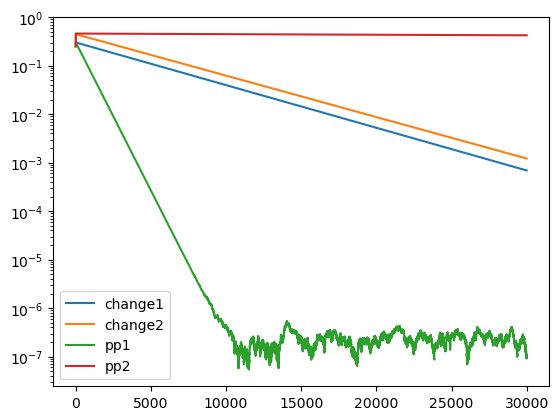

In [34]:
plt.semilogy(output03_pp_change1["Gradient_two_norm"][:],label='change1')
plt.semilogy(output03_pp_change2["Gradient_two_norm"][:],label='change2')
plt.semilogy(output03_pp_1["Gradient_two_norm"][:],label='pp1')
plt.semilogy(output03_pp_2["Gradient_two_norm"][:],label='pp2')


plt.legend()
plt.show()

In [35]:
max_it, history_gradient_two_norm, cs_error, loss_history, x=push_diging_no_accuracy(C=B, init_x=init_x, h_data=h, y_data=y, grad_func=grad, loss_func=loss, grad_f_bar_func=grad_f_bar_x, d=d, L=L, rho=10, lr=1e-4,sigma_n=1e-7, max_it=3000, mg=1, decay=1)

output03_pd = pd.DataFrame({
        "Iteration": range(1 + max_it),
        "Gradient_two_norm": history_gradient_two_norm,
        "Consensus_error": cs_error,
        "Loss": loss_history,
        #"Accuracy":accuracy,
    })

output03_pd

,Iteration,Gradient_two_norm,Consensus_error,Loss
0,0,0.251574,4.167812e-02,4.857831
1,1,0.251299,5.439290e-18,4.854109
2,2,0.250790,8.529804e-18,4.854097
3,3,0.250282,5.398453e-18,4.854085
4,4,0.249775,8.441709e-18,4.854073
...,...,...,...,...
2996,2996,0.000578,4.503747e-19,4.849972
2997,2997,0.000577,2.069001e-18,4.849972
2998,2998,0.000576,1.104185e-18,4.849972
2999,2999,0.000575,2.150124e-18,4.849972


In [36]:
plt.semilogy(output03_pp["Gradient_two_norm"][:],label='push pull, lr=1e-4')
plt.semilogy(output03_pd["Gradient_two_norm"][:],label='push diging,lr=1e-4')
plt.semilogy(output03_pp_change["Gradient_two_norm"][:],label='change')
plt.legend()
plt.show()

NameError: name 'output03_pp' is not defined

speed up

In [ ]:
n=5
d=5
L=200

I=np.eye(n)
A=generate_row_stochastic_matrix(n=n,seed_location=37,seed_num=33,seed_value=912)
B=row_to_column_stochastic(A,seed=85)
A=column_to_row_stochastic(B,seed=400)
show_row(A)
show_col(B)

init_x = init_x_func(n=n, d=d, seed=465)
h,y,x_opt,x_star=init_data(n=n,d=d,L=L,seed=4989,sigma_h=30)

A的第二大特征值: 0.5007780868881226
A的beta: 0.8519894685797631
A的spectral gap: 0.1480105314202369
A的kappa: 1.5645618933961065
S_A是: 43.73938856677399 

B的第二大特征值: 0.37244065687612454
B的beta 0.7805190840670402
B的spectral gap: 0.21948091593295982
B的kappa: 3.269419498070146
S_B是: 44.5135916454762 



In [ ]:
max_it, history_gradient_two_norm, cs_error, loss_history, x=push_pull_no_accuracy(A=A, B=B, init_x=init_x, h_data=h, y_data=y, grad_func=grad, loss_func=loss, grad_f_bar_func=grad_f_bar_x, d=d, L=L, rho=10, lr=1e-6,sigma_n=1e-3, max_it=300000, mg=1, decay=1)

o1 = pd.DataFrame({
        "Iteration": range(1 + max_it),
        "Gradient_two_norm": history_gradient_two_norm,
        "Consensus_error": cs_error,
        "Loss": loss_history,
        #"Accuracy":accuracy,
    })

o1

,Iteration,Gradient_two_norm,Consensus_error,Loss
0,0,0.319491,4.041882e-02,3.473387
1,1,0.310896,1.240848e-02,3.469689
2,2,0.324633,6.218117e-03,3.469767
3,3,0.326616,2.982782e-03,3.469694
4,4,0.325260,1.060040e-03,3.469605
...,...,...,...,...
299996,299996,0.000567,4.791001e-09,3.461653
299997,299997,0.000567,8.279738e-09,3.461653
299998,299998,0.000567,7.837356e-09,3.461653
299999,299999,0.000567,5.898473e-09,3.461653


In [ ]:
n=50
d=5
L=200

I=np.eye(n)
A=generate_row_stochastic_matrix(n=n,seed_location=37,seed_num=33,seed_value=912)
B=row_to_column_stochastic(A,seed=85)
A=column_to_row_stochastic(B,seed=400)
show_row(A)
show_col(B)

init_x = init_x_func(n=n, d=d, seed=465)
h,y,x_opt,x_star=init_data(n=n,d=d,L=L,seed=4989,sigma_h=30)

A的第二大特征值: 0.4068815377046413
A的beta: 0.6284451836688141
A的spectral gap: 0.3715548163311859
A的kappa: 3.505359261247493
S_A是: 85.80299904818271 

B的第二大特征值: 0.1798014260893665
B的beta 0.3844745269217867
B的spectral gap: 0.6155254730782134
B的kappa: 55.03781869382512
S_B是: 115.06283506625434 



In [ ]:
max_it, history_gradient_two_norm, cs_error, loss_history, x=push_pull_no_accuracy(A=A, B=B, init_x=init_x, h_data=h, y_data=y, grad_func=grad, loss_func=loss, grad_f_bar_func=grad_f_bar_x, d=d, L=L, rho=10, lr=1e-6,sigma_n=1e-3, max_it=3000, mg=1, decay=1)

o2 = pd.DataFrame({
        "Iteration": range(1 + max_it),
        "Gradient_two_norm": history_gradient_two_norm,
        "Consensus_error": cs_error,
        "Loss": loss_history,
        #"Accuracy":accuracy,
    })

o2

,Iteration,Gradient_two_norm,Consensus_error,Loss
0,0,0.106386,8.235391e-02,34.668558
1,1,0.100871,2.585783e-02,34.659772
2,2,0.103114,8.103537e-03,34.659213
3,3,0.103017,3.387116e-03,34.659101
4,4,0.103125,1.266943e-03,34.659074
...,...,...,...,...
2996,2996,0.097404,4.757265e-07,34.658620
2997,2997,0.097402,4.797996e-07,34.658620
2998,2998,0.097400,4.735938e-07,34.658620
2999,2999,0.097398,4.754554e-07,34.658620


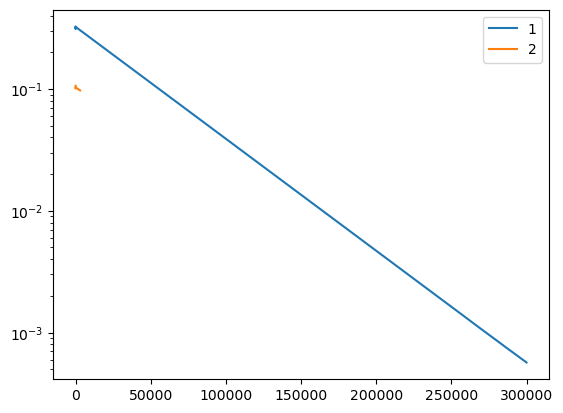

In [ ]:
plt.semilogy(o1["Gradient_two_norm"][:],label='1')
plt.semilogy(o2["Gradient_two_norm"][:],label='2')

plt.legend()
plt.show()